**Modelo de red neuronal MLP**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo MLP
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential,model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


Se obtiene conjunto de datos

In [ ]:
df=pd.read_csv('df.csv')
df=df.drop(['Year', 'Week', 'Day','Month','Size','Type'], axis=1)

In [ ]:
df.set_index('Date', inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380380 entries, 2010-02-05 to 2012-10-26
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         380380 non-null  int64  
 1   Dept          380380 non-null  int64  
 2   Weekly_Sales  380380 non-null  float64
 3   IsHoliday     380380 non-null  bool   
 4   Temperature   380380 non-null  float64
 5   Fuel_Price    380380 non-null  float64
 6   MarkDown1     380380 non-null  float64
 7   MarkDown2     380380 non-null  float64
 8   MarkDown3     380380 non-null  float64
 9   MarkDown4     380380 non-null  float64
 10  MarkDown5     380380 non-null  float64
 11  CPI           380380 non-null  float64
 12  Unemployment  380380 non-null  float64
dtypes: bool(1), float64(10), int64(2)
memory usage: 38.1+ MB


In [ ]:
df.shape

(380380, 13)

In [ ]:
#Setear semilla
np.random.seed(42)

#2. Obtener series de Tiempo

*Se obtiene lista de dataframe ordenados por Store y Dept*

In [ ]:
series_time=[]
lista_Store=df.Store.unique()
lista_Store.sort()
lista_dept=df.Dept.unique()
lista_dept.sort()

for i in lista_Store:
  for j in lista_dept:
    #lista=[]
    test=df[(df.Store==i) & (df.Dept==j)]
    if(test.empty!=True):
        series_time.append(test)

In [ ]:
len(series_time)

2660

#3.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [ ]:
#Seleccion de caracteristicas
features =features = [feature for feature in df.columns if feature not in ('Store','Dept')]

#Se define escalado
std_scaler = StandardScaler()

series_time_scaled=[]

#Transformacion
for serie in series_time:
  for i in features:
    serie[i]=std_scaler.fit_transform(serie[i].values.reshape(-1,1))
  series_time_scaled.append(serie)

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

series_time_scaled[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,
2010-02-05,1,1,0.245542,-0.274204,-1.830686,-1.521079,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.130288,1.295958
2010-02-12,1,1,2.395781,3.646917,-2.098280,-1.577441,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.096657,1.295958
2010-02-19,1,1,1.943233,-0.274204,-1.998285,-1.657288,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.085823,1.295958
2010-02-26,1,1,-0.316684,-0.274204,-1.526473,-1.546911,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.078788,1.295958
2010-03-05,1,1,-0.069800,-0.274204,-1.535627,-1.396612,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.071754,1.295958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,-0.363093,-0.274204,0.547388,1.048107,0.141879,-0.191745,-0.091796,0.020611,0.956274,1.611008,-1.836849
2012-10-05,1,1,-0.062002,-0.274204,0.017127,0.933034,0.943562,-0.193456,-0.088232,0.573847,0.594358,1.657095,-2.712884
2012-10-12,1,1,0.025529,-0.274204,-0.374406,0.895459,-0.145256,-0.193456,-0.090407,-0.184537,1.338915,1.703183,-2.712884


In [ ]:
len(series_time_scaled)

2660

In [ ]:
import random
series_time_scaled=random.sample(series_time_scaled,20)

#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_predic=[]
series_target=[]
for serie in series_time_scaled:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [ ]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head()

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0)
Date,,,,,,,,,,,,,
2010-02-12,4.0,25.0,0.057108,-0.274204,-1.146992,-1.489682,-0.503168,-0.192089,-0.096222,-0.358879,-0.591212,-1.208346,1.876953
2010-02-19,4.0,25.0,-0.338450,3.646917,-2.072358,-1.549850,-0.503168,-0.192089,-0.096222,-0.358879,-0.591212,-1.179081,1.876953
2010-02-26,4.0,25.0,-0.610926,-0.274204,-1.600372,-1.629271,-0.503168,-0.192089,-0.096222,-0.358879,-0.591212,-1.162865,1.876953
2010-03-05,4.0,25.0,-1.192679,-0.274204,-1.295845,-1.508936,-0.503168,-0.192089,-0.096222,-0.358879,-0.591212,-1.148825,1.876953
2010-03-12,4.0,25.0,-1.255793,-0.274204,-1.163738,-1.354907,-0.503168,-0.192089,-0.096222,-0.358879,-0.591212,-1.134785,1.876953


In [ ]:
#Ejemplo de variables objetivo de una serie
series_target[0].head()

,Weekly_Sales(t+1)
Date,
2010-02-12,-0.338450
2010-02-19,-0.610926
2010-02-26,-1.192679
2010-03-05,-1.255793
2010-03-12,-1.068072


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])


shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#MLP

In [ ]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Función para crear el modelo
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion del modelo MLP
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(Dense(neurons))
        model.add(Dropout(dropout))

    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [ ]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_, y_test_ = Y_train.iloc[train_index], Y_train.iloc[test_index]

      # Crear el modelo de LSTM
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [ ]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 64, 576, 32),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),
}

In [ ]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)


100%|██████████| 50/50 [1:14:40<00:00, 89.61s/trial, best loss: 29.88457533121109]
Los mejores hiperparámetros son:  {'batch_size': 30.0, 'dropout': 0.45283035994504073, 'layers': 3.0, 'learning_rate': 2.7379182557837892e-05, 'neurons': 320.0}


In [ ]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores_test']

In [ ]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [ ]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 30.0,
 'dropout': 0.45283035994504073,
 'epochs': 800,
 'layers': 3.0,
 'learning_rate': 2.7379182557837892e-05,
 'neurons': 320.0,
 'optimizer': 'adam'}

# 6.Evaluacion del modelo

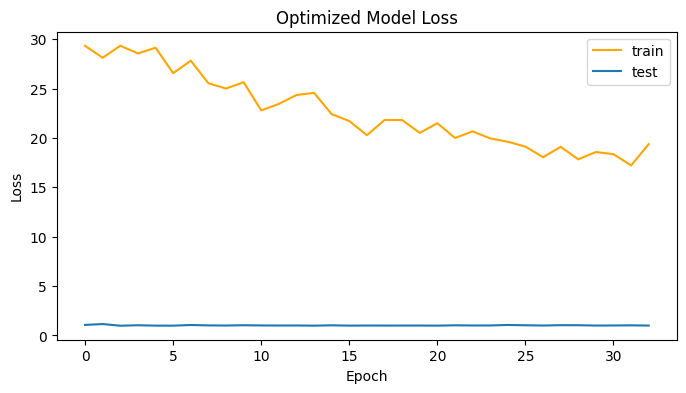

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#Se realiza prediccion
results = best_model.predict(X_test)

19/19 [==============================] - 0s 2ms/step


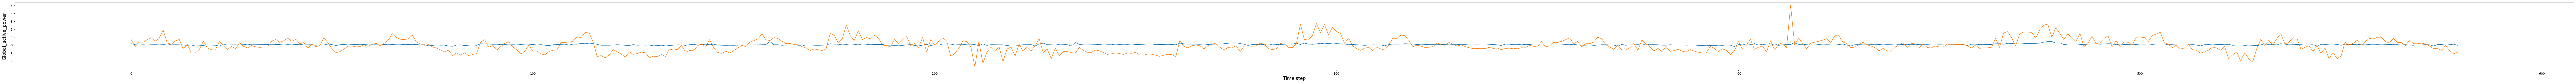

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(X_test.shape[0])]
plt.figure(figsize=(150,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.show()

In [ ]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.6622299551963806
RMSE: 0.8137751221656799
MAE: 0.6281049251556396
MAPE: 119.59626770019531


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "MLP_Wallmart""_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [ ]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])


In [ ]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
63,MLP_Wallmart_13_4_800_20.0_2.0_416.0_0.52_adam...,13,4,22.453038,0.452941,0.673009,0.497926,176.674988
23,MLP_Wallmart_5_4_800_70.0_1.0_224.0_0.49_adam_...,5,4,9.778895,0.454599,0.674240,0.500750,171.819305
24,MLP_Wallmart_5_5_800_70.0_1.0_224.0_0.49_adam_...,5,5,4.642483,0.460354,0.678494,0.505545,170.328751
248,MLP_Wallmart_50_4_800_20.0_1.0_224.0_0.46_adam...,50,4,13.896975,0.468057,0.684147,0.506974,168.532791
62,MLP_Wallmart_13_3_800_20.0_2.0_416.0_0.52_adam...,13,3,7.579901,0.468259,0.684294,0.510273,146.675659


In [ ]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_MLP_Wallmart.csv')

In [ ]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_MLP'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

Se guarda cada modelo keras en un objeto Json

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "MLP_Wallmart"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1